In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as lines
import xesmf as xe
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import cartopy.crs as ccrs
import copy
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

In [2]:
def regridder_stable(file, variable):
    # read in data from nc file
    # 960: 1930
    # 960+600: 1980
    ds = xr.open_dataset(file)
    if variable == 'TEMP':
        ds_pr = ds[variable][0, 0, :, :]
        if "SST" not in file:
            del ds['ULONG']
            del ds['ULAT']
    else:
        ds_pr = ds[variable]#[:, :, :]
    
    # define the grid of the output file
    ds_out = xr.Dataset(
        {"lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.5, 360.5, 1.0)),})
    
    # build regridder and calculate
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    ds_pr_out = regridder(ds_pr)
    
    # calculate the mean precipitation over some area
    # lat: 90-110 = 0.5 - 19.5 
    # lon: 130-270 = 130.5 - 269.5
    # pr_ts = ds_pr_out[:,95:105,130:270].mean(axis=1).mean(axis=1)
    
    return np.array(ds_pr_out)

In [3]:
PRE_Control = regridder_stable("/home/zl457/climo_atm/C6_B1850_Control_ANN_005101_010012_climo.nc", 'PRECC') + regridder_stable("/home/zl457/climo_atm/C6_B1850_Control_ANN_005101_010012_climo.nc", 'PRECL')
PRE_TRI_3 = regridder_stable("/home/zl457/climo_atm/C6_B1850_tri_3_ANN_005101_010012_climo.nc", 'PRECC') + regridder_stable("/home/zl457/climo_atm/C6_B1850_tri_3_ANN_005101_010012_climo.nc", 'PRECL')
PRE_ITCZ = regridder_stable("/home/zl457/atm_NEP30SEP-10.nc", 'PRECC') + regridder_stable("/home/zl457/atm_NEP30SEP-10.nc", 'PRECL')

PRE_Control_2xCO2 = regridder_stable("/home/zl457/climo_atm/C6_B1850_Control_2xCO2_ANN_015101_020012_climo.nc", 'PRECC') + regridder_stable("/home/zl457/climo_atm/C6_B1850_Control_2xCO2_ANN_015101_020012_climo.nc", 'PRECL')
PRE_TRI_3_2xCO2 = regridder_stable("/home/zl457/climo_atm/C6_B1850_tri_3_2xCO2_ANN_015101_020012_climo.nc", 'PRECC') + regridder_stable("/home/zl457/climo_atm/C6_B1850_tri_3_2xCO2_ANN_015101_020012_climo.nc", 'PRECL')
PRE_ITCZ_2xCO2 = regridder_stable("/home/zl457/atm_NEP30SEP-10_2xCO2.nc", 'PRECC') + regridder_stable("/home/zl457/atm_NEP30SEP-10_2xCO2.nc", 'PRECL')


In [4]:
ERA5 = "ERA5_194001-202312.nc"
PRE_ERA5 = regridder_stable(ERA5, 'tp') / 86400

In [5]:
PRE_Control = PRE_Control.mean(axis=0)
PRE_TRI_3 = PRE_TRI_3.mean(axis=0)
PRE_ITCZ = PRE_ITCZ[600:,:,:].mean(axis=0)

PRE_Control_2xCO2 = PRE_Control_2xCO2.mean(axis=0)
PRE_TRI_3_2xCO2 = PRE_TRI_3_2xCO2.mean(axis=0)
PRE_ITCZ_2xCO2 = PRE_ITCZ_2xCO2[600:,:,:].mean(axis=0)

PRE_ERA5 = PRE_ERA5[-540:, :, :].mean(axis=0)

In [6]:
def plot_pr(pr, diff, ax, box):
    if not diff:
        scale = np.linspace(0, 12, 13)
        color = cm.viridis
    else:
        scale = np.linspace(-4, 4, 17)
        color = cmap=cm.BrBG
        
    #ax.subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=180))
    f = ax.contourf(np.arange(-180.5, 179.5, 1.0), np.arange(-89.5, 90.5, 1.0), pr*86400*1000, cmap=color, levels=scale, extend='both')
    ax.set_extent([90, 300, -45, 45], ccrs.PlateCarree())
    #ax.add_artist(lines.Line2D(np.linspace(-49, 80, 130), np.arange(0.5, 15.5, 1).reshape(1,15) @ pr[i][:,90:105,130:260].mean(axis=0) / pr[i][:,90:105,130:260].mean(axis=0).sum(axis=0), color='w'))
    #ax.add_artist(lines.Line2D(np.linspace(-29, 30, 60), np.arange(-14.5, 0.5, 1).reshape(1,15) @ pr[i][:,75:90,150:210].mean(axis=0) / pr[i][:,75:90,150:210].mean(axis=0).sum(axis=0), color='w'))
    if box:  
        ax.add_artist(lines.Line2D([30, 100], [25, 25], color='b', alpha=0.5))
        ax.add_artist(lines.Line2D([30, 100], [10, 10], color='b', alpha=0.5))
        ax.add_artist(lines.Line2D([30, 30], [25, 10], color='b', alpha=0.5))
        ax.add_artist(lines.Line2D([100, 100], [25, 10], color='b', alpha=0.5))
    
        ax.add_artist(lines.Line2D([30, 100], [2, 2], color='r', alpha=0.5))
        ax.add_artist(lines.Line2D([30, 100], [10, 10], color='r', alpha=0.5))
        ax.add_artist(lines.Line2D([30, 30], [2, 10], color='r', alpha=0.5))
        ax.add_artist(lines.Line2D([100, 100], [2, 10], color='r', alpha=0.5))
    
        ax.add_artist(lines.Line2D([30, 100], [2, 2], color='b', alpha=0.5))
        ax.add_artist(lines.Line2D([30, 100], [-10, -10], color='b', alpha=0.5))
        ax.add_artist(lines.Line2D([30, 30], [2, -10], color='b', alpha=0.5))
        ax.add_artist(lines.Line2D([100, 100], [2, -10], color='b', alpha=0.5))
    
    ax.coastlines()
    cbar = fig.colorbar(f, orientation="horizontal")
    cbar.set_label(label="$mm/day$", fontsize=15, loc="right")
    cbar.ax.set_xticklabels(labels=scale, fontsize=15)
    g = ax.gridlines(draw_labels=True, xlocs=[-90,-120,-150,30,60,90,120,150,180], ylocs=[-45, -30, -15, 0, 15, 30, 45])
    g.top_labels = False
    g.right_labels = False
    g.xlabel_style = {'size': 13}
    g.ylabel_style = {'size': 13}

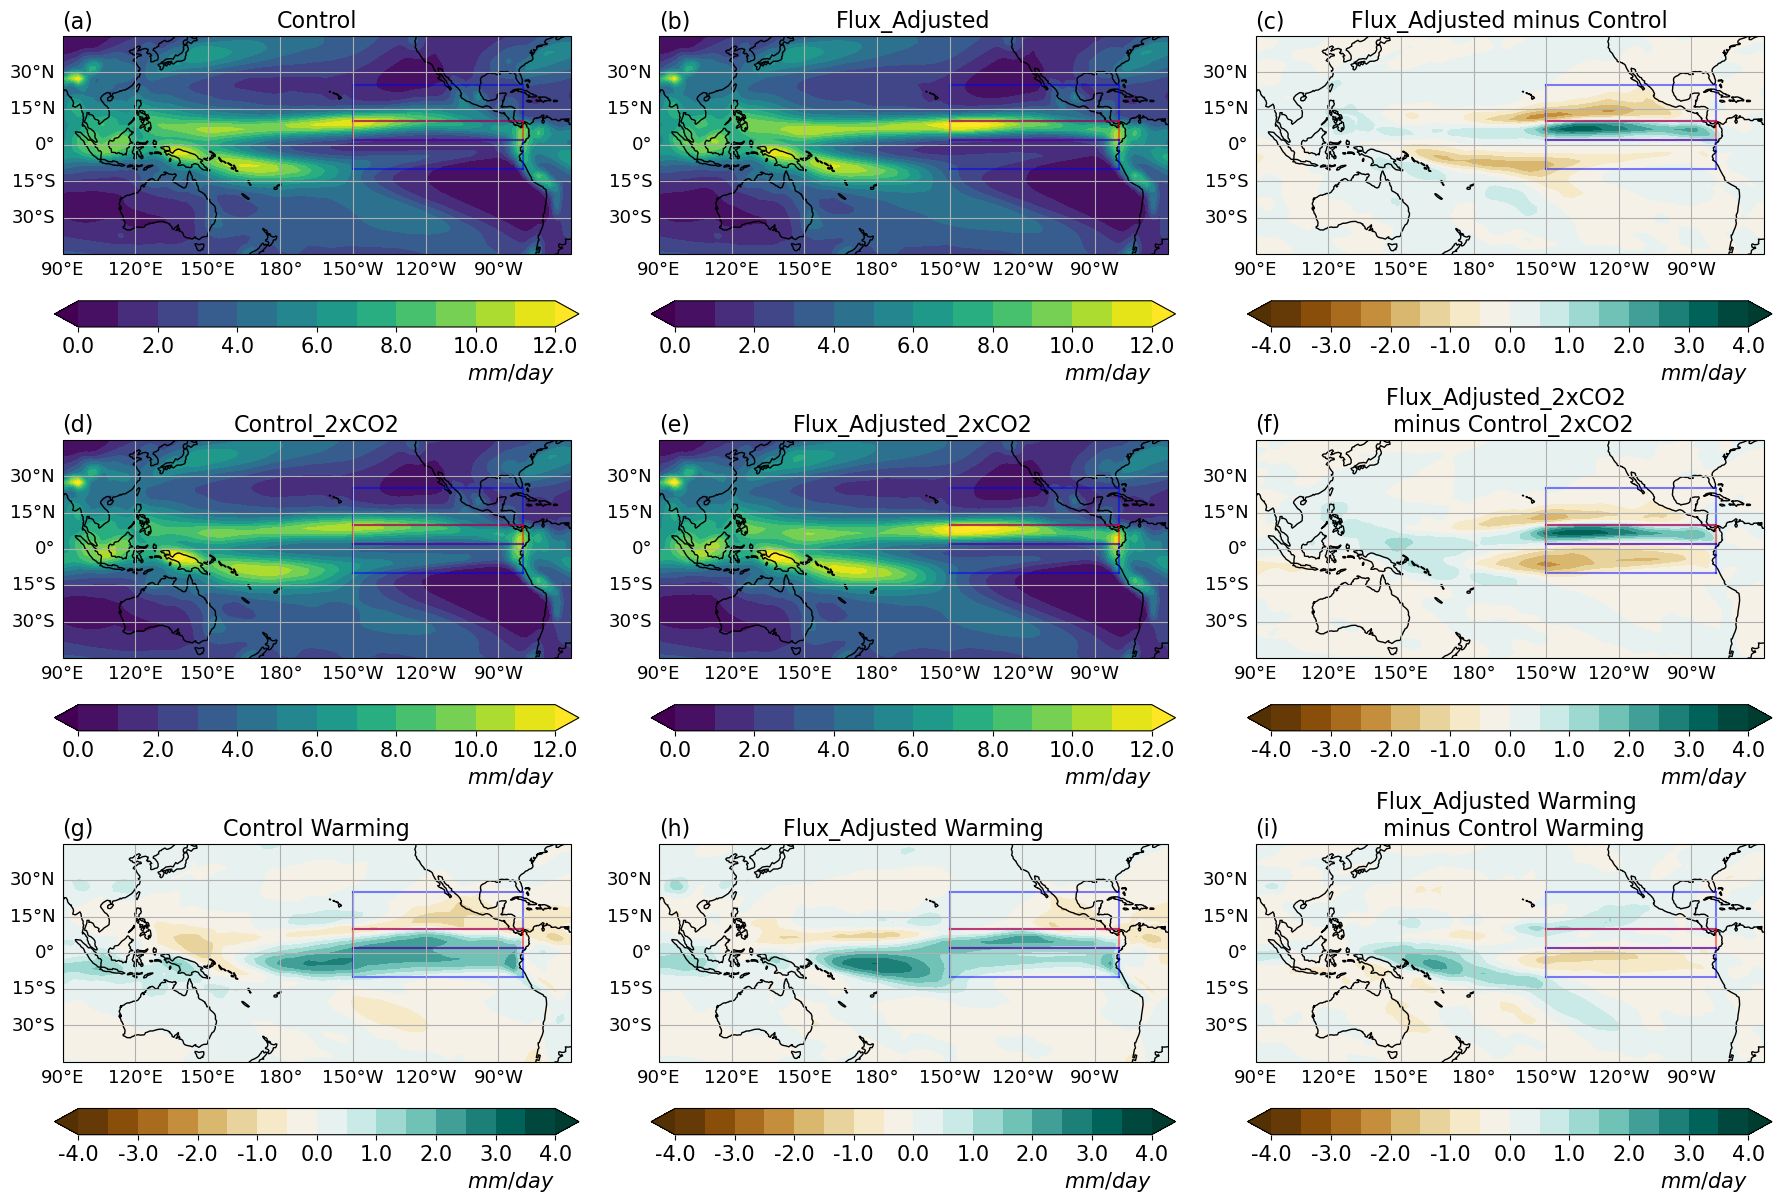

In [8]:
fig, axes = plt.subplots(3,3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
plot_pr(PRE_Control, diff=False, ax=axes[0][0], box=True)
axes[0][0].set_title("Control", fontsize=16)
axes[0][0].set_title("(a)", loc='left', fontsize=16)
plot_pr(PRE_TRI_3, diff=False, ax=axes[0][1], box=True)
axes[0][1].set_title("Flux_Adjusted", fontsize=16)
axes[0][1].set_title("(b)", loc='left', fontsize=16)
plot_pr(PRE_TRI_3 - PRE_Control, diff=True, ax=axes[0][2], box=True)
axes[0][2].set_title("Flux_Adjusted minus Control", fontsize=16)
axes[0][2].set_title("(c)", loc='left', fontsize=16)


plot_pr(PRE_Control_2xCO2, diff=False, ax=axes[1][0], box=True)
axes[1][0].set_title("Control_2xCO2", fontsize=16)
axes[1][0].set_title("(d)", loc='left', fontsize=16)
plot_pr(PRE_TRI_3_2xCO2, diff=False, ax=axes[1][1], box=True)
axes[1][1].set_title("Flux_Adjusted_2xCO2", fontsize=16)
axes[1][1].set_title("(e)", loc='left', fontsize=16)
plot_pr(PRE_TRI_3_2xCO2 - PRE_Control_2xCO2, diff=True, ax=axes[1][2], box=True)
axes[1][2].set_title("Flux_Adjusted_2xCO2 \n minus Control_2xCO2", fontsize=16)
axes[1][2].set_title("(f)", loc='left', fontsize=16)


plot_pr(PRE_Control_2xCO2 - PRE_Control, diff=True, ax=axes[2][0], box=True)
axes[2][0].set_title("Control Warming", fontsize=16)
axes[2][0].set_title("(g)", loc='left', fontsize=16)
plot_pr(PRE_TRI_3_2xCO2 - PRE_TRI_3, diff=True, ax=axes[2][1], box=True)
axes[2][1].set_title("Flux_Adjusted Warming", fontsize=16)
axes[2][1].set_title("(h)", loc='left', fontsize=16)
plot_pr((PRE_TRI_3_2xCO2 - PRE_TRI_3) - (PRE_Control_2xCO2 - PRE_Control), diff=True, ax=axes[2][2], box=True)
axes[2][2].set_title("Flux_Adjusted Warming \n minus Control Warming", fontsize=16)
axes[2][2].set_title("(i)", loc='left', fontsize=16)


plt.tight_layout()

plt.savefig("Fig3.pdf")

In [9]:
left, right = 210, 270
PRE_ERA5_profile = np.nanmean(PRE_ERA5[:, left:right] * 86400 * 1000, axis=1)  # take the mean of 150W - 90W

PRE_Control_profile = np.nanmean(PRE_Control[:, left:right] * 86400 * 1000, axis=1)  # take the mean of 150W - 90W
PRE_Control_2xCO2_profile = np.nanmean(PRE_Control_2xCO2[:, left:right] * 86400 * 1000, axis=1)  # take the mean of 150W - 90W

PRE_TRI_3_profile = np.nanmean(PRE_TRI_3[:, left:right] * 86400 * 1000, axis=1)  # take the mean of 150W - 90W
PRE_TRI_3_2xCO2_profile = np.nanmean(PRE_TRI_3_2xCO2[:, left:right] * 86400 * 1000, axis=1)  # take the mean of 150W - 90W

PRE_ITCZ_profile = np.nanmean(PRE_ITCZ[:, left:right] * 86400 * 1000, axis=1)  # take the mean of 150W - 90W
PRE_ITCZ_2xCO2_profile = np.nanmean(PRE_ITCZ_2xCO2[:, left:right] * 86400 * 1000, axis=1)  # take the mean of 150W - 90W

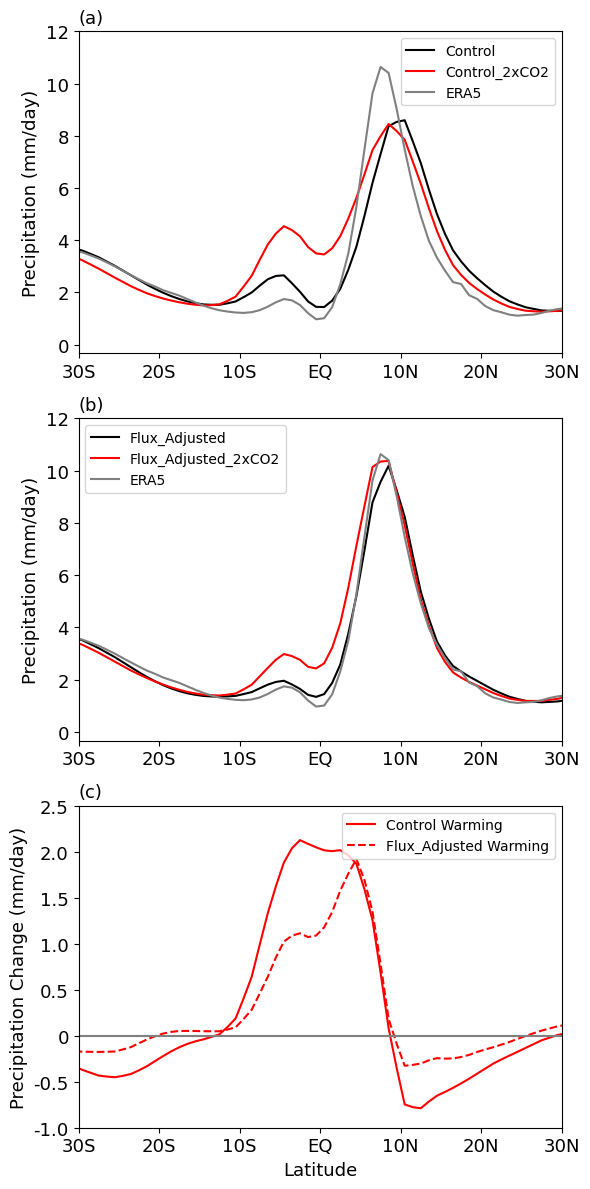

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(6, 12))
lat = np.arange(-89.5, 90.5, 1)
#ax1.set_title('Meridional Profile')
#ax1.set_title(f'{360-left}W-{360-right}W', loc='right')
axes[0].plot(lat, PRE_Control_profile, 'k', label = 'Control')
axes[0].plot(lat, PRE_Control_2xCO2_profile, 'r', label = 'Control_2xCO2')
axes[0].plot(lat, PRE_ERA5_profile, 'gray', label = 'ERA5')

axes[0].set_title("(a)", loc='left', fontsize=13)
axes[0].set_ylabel('Precipitation (mm/day)', size=13)
axes[0].set_yticks([0,2,4,6,8,10,12])
axes[0].set_yticklabels([0,2,4,6,8,10,12], size=13)
axes[0].set_xticks([-90,-60,-30,-20,-10,0,10,20,30,60,90])
axes[0].set_xticklabels(['90S', '60S', '30S', '20S', '10S', 'EQ', '10N', '20N','30N', '60N', '90N'], size=13)
axes[0].set_xlim(-30, 30)
axes[0].legend()

#axes[0].axhline(y=2.7, color='k', linestyle=':')
#axes[0].axhline(y=4.6, color='k', linestyle=':')

axes[1].plot(lat, PRE_TRI_3_profile, 'k', label = 'Flux_Adjusted')
axes[1].plot(lat, PRE_TRI_3_2xCO2_profile, color='r', linestyle='-', label = 'Flux_Adjusted_2xCO2')
axes[1].plot(lat, PRE_ERA5_profile, 'gray', label = 'ERA5')
axes[1].set_title("(b)", loc='left', fontsize=13)
axes[1].set_ylabel('Precipitation (mm/day)', size=13)
axes[1].set_yticks([0,2,4,6,8,10,12])
axes[1].set_yticklabels([0,2,4,6,8,10,12], size=13)
axes[1].set_xticks([-90,-60,-30,-20,-10,0,10,20,30,60,90])
axes[1].set_xticklabels(['90S', '60S', '30S', '20S', '10S', 'EQ', '10N', '20N','30N', '60N', '90N'], size=13)
axes[1].set_xlim(-30, 30)
axes[1].legend()

#axes[1].axhline(y=2.0, color='r', linestyle=':')
#axes[1].axhline(y=3.0, color='r', linestyle=':')


axes[2].set_title("(c)", loc='left', fontsize=13)
axes[2].plot(lat, PRE_Control_2xCO2_profile - PRE_Control_profile, 'r', label = 'Control Warming')
axes[2].plot(lat, PRE_TRI_3_2xCO2_profile - PRE_TRI_3_profile, 'r--', label = 'Flux_Adjusted Warming')

axes[2].set_ylabel('Precipitation Change (mm/day)', size=13)
axes[2].set_xlabel('Latitude', size=13)
axes[2].set_yticks([-1.0,-0.5,0,0.5,1.0,1.5,2.0,2.5])
axes[2].set_yticklabels([-1.0,-0.5,0,0.5,1.0,1.5,2.0,2.5], size=13)
axes[2].set_xticks([-90,-60,-30,-20,-10,0,10,20,30,60,90])
axes[2].set_xticklabels(['90S', '60S', '30S', '20S', '10S', 'EQ', '10N', '20N','30N', '60N', '90N'], size=13)
axes[2].set_xlim(-30, 30)
axes[2].axhline(y=0.0, color='grey', linestyle='-')
axes[2].legend()

plt.tight_layout()
plt.savefig("Fig4.pdf")